In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample
import warnings
import pickle
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
from sklearn.metrics import accuracy_score, roc_auc_score, cohen_kappa_score, plot_confusion_matrix, roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import seaborn as sns

from sklearn.preprocessing import LabelEncoder
import numpy as np
import random


In [2]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='Z4ajsELcWFdx1gZSJC0YtWrw6a8MHtY85DozrpvEoh3a',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us.cloud-object-storage.appdomain.cloud')

bucket = 'modelbuilding-donotdelete-pr-a7cydwsuquegtp'
object_key = 'weatherAUS.csv - weatherAUS.csv'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

data = pd.read_csv(body)
data.head()


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,01-12-2008,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,02-12-2008,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,03-12-2008,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,04-12-2008,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,05-12-2008,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [3]:
data.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

In [5]:
data['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True)
data['RainTomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)

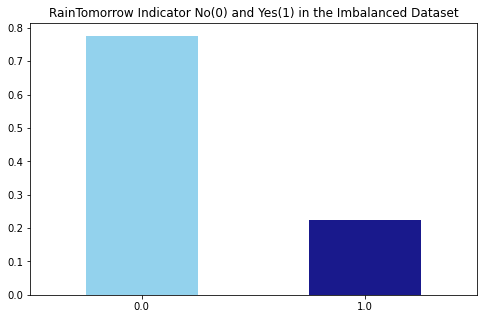

In [6]:
#Check if data is balanced or not

fig = plt.figure(figsize = (8,5))
data.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) in the Imbalanced Dataset')
plt.show()

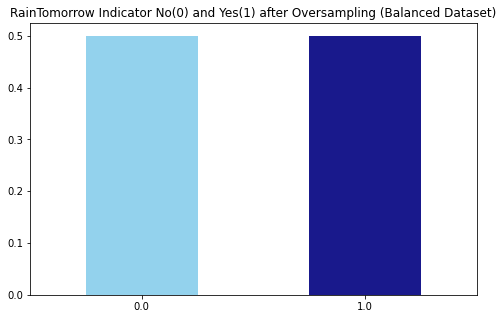

In [7]:
#Handle data with imbalance by oversampling

no = data[data.RainTomorrow == 0]
yes = data[data.RainTomorrow == 1]
yes_oversampled = resample(yes, replace=True, n_samples=len(no), random_state=123)
oversampled = pd.concat([no, yes_oversampled])

fig = plt.figure(figsize = (8,5))
oversampled.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) after Oversampling (Balanced Dataset)')
plt.show()

In [8]:
#Looking for null values
oversampled.isna().sum()

Date                  0
Location              0
MinTemp            1082
MaxTemp             471
Rainfall           3124
Evaporation       95411
Sunshine         104831
WindGustDir       15491
WindGustSpeed     15354
WindDir9am        14728
WindDir3pm         6440
WindSpeed9am       2206
WindSpeed3pm       4353
Humidity9am        3171
Humidity3pm        6031
Pressure9am       21728
Pressure3pm       21746
Cloud9am          81339
Cloud3pm          85614
Temp9am            1653
Temp3pm            4558
RainToday          3124
RainTomorrow          0
dtype: int64

In [9]:
#Handle data with missing values by imputing
oversampled.select_dtypes(include=['object']).columns

Index(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], dtype='object')

In [10]:
# Impute categorical var with Mode
oversampled['Date'] = oversampled['Date'].fillna(oversampled['Date'].mode()[0])
oversampled['Location'] = oversampled['Location'].fillna(oversampled['Location'].mode()[0])
oversampled['WindGustDir'] = oversampled['WindGustDir'].fillna(oversampled['WindGustDir'].mode()[0])
oversampled['WindDir9am'] = oversampled['WindDir9am'].fillna(oversampled['WindDir9am'].mode()[0])
oversampled['WindDir3pm'] = oversampled['WindDir3pm'].fillna(oversampled['WindDir3pm'].mode()[0])

In [11]:
# Convert categorical features to continuous features with Label Encoding
lencoders = {}
for col in oversampled.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    oversampled[col] = lencoders[col].fit_transform(oversampled[col])

In [12]:
lencoders
pickle.dump(lencoders,open('encoder.pkl','wb'))

In [13]:
warnings.filterwarnings("ignore")
# Multiple Imputation by Chained Equations
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
MiceImputed = oversampled.copy(deep=True) 
mice_imputer = IterativeImputer()
MiceImputed.iloc[:, :] = mice_imputer.fit_transform(oversampled)

In [14]:
# Detecting outliers with IQR
Q1 = MiceImputed.quantile(0.25)
Q3 = MiceImputed.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Date             1712.000000
Location           25.000000
MinTemp             9.300000
MaxTemp            10.200000
Rainfall            2.400000
Evaporation         4.069582
Sunshine            5.983632
WindGustDir         9.000000
WindGustSpeed      19.000000
WindDir9am          8.000000
WindDir3pm          8.000000
WindSpeed9am       13.000000
WindSpeed3pm       11.000000
Humidity9am        26.000000
Humidity3pm        30.000000
Pressure9am         8.800000
Pressure3pm         8.800000
Cloud9am            4.000000
Cloud3pm            3.691648
Temp9am             9.300000
Temp3pm             9.800000
RainToday           1.000000
RainTomorrow        1.000000
dtype: float64


In [15]:
# Removing outliers from the dataset
MiceImputed = MiceImputed[~((MiceImputed < (Q1 - 1.5 * IQR)) |(MiceImputed > (Q3 + 1.5 * IQR))).any(axis=1)]
MiceImputed.shape

(170498, 23)

In [16]:
# Standardizing data
r_scaler = preprocessing.MinMaxScaler()
r_scaler.fit(MiceImputed)
modified_data = pd.DataFrame(r_scaler.transform(MiceImputed), index=MiceImputed.index, columns=MiceImputed.columns)


In [17]:
# Feature Importance using Filter Method (Chi-Square)
X = modified_data.loc[:,modified_data.columns!='RainTomorrow']
y = modified_data[['RainTomorrow']]
selector = SelectKBest(chi2, k=10)
selector.fit(X, y)
X_new = selector.transform(X)
print(X.columns[selector.get_support(indices=True)])

Index(['Rainfall', 'Sunshine', 'WindGustSpeed', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'RainToday'],
      dtype='object')


In [18]:

X = MiceImputed.drop('RainTomorrow', axis=1)
y = MiceImputed['RainTomorrow']
selector = SelectFromModel(rf(n_estimators=100, random_state=0))
selector.fit(X, y)
support = selector.get_support()
features = X.loc[:,support].columns.tolist()
print(features)
print(rf(n_estimators=100, random_state=0).fit(X,y).feature_importances_)


['Sunshine', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm']
[0.03094334 0.02890495 0.03301456 0.03237542 0.02132193 0.03321251
 0.13794989 0.02102881 0.04241191 0.02137696 0.0222857  0.0217154
 0.02374655 0.03459154 0.10599028 0.04846918 0.0612174  0.05629396
 0.14311787 0.03123585 0.03627315 0.01252283]


In [19]:
#Training Rainfall Prediction Model With Different Models
features = MiceImputed[['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 
                       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 
                       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 
                       'RainToday']]
target = MiceImputed['RainTomorrow']

# Split into test and train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=12345)

# Normalize Features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [21]:
#Function to plot the roc_curve
def plot_roc_cur(fper, tper):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [22]:
def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
    t0=time.time()
    if verbose == False:
        model.fit(X_train,y_train, verbose=0)
    else:
        model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred) 
    coh_kap = cohen_kappa_score(y_test, y_pred)
    time_taken = time.time()-t0
    print("Accuracy = {}".format(accuracy))
    print("ROC Area under Curve = {}".format(roc_auc))
    print("Cohen's Kappa = {}".format(coh_kap))
    print("Time taken = {}".format(time_taken))
    print(classification_report(y_test,y_pred,digits=5))
    
    probs = model.predict_proba(X_test)  
    probs = probs[:, 1]  
    fper, tper, thresholds = roc_curve(y_test, probs) 
    plot_roc_cur(fper, tper)
    
    plot_confusion_matrix(model, X_test, y_test,cmap=plt.cm.Blues, normalize = 'all')
    
    return model, accuracy, roc_auc, coh_kap, time_taken

Accuracy = 0.796950146627566
ROC Area under Curve = 0.7909527583519237
Cohen's Kappa = 0.5855969268071239
Time taken = 2.724815607070923
              precision    recall  f1-score   support

         0.0    0.80393   0.84197   0.82251     23818
         1.0    0.78710   0.73994   0.76279     18807

    accuracy                        0.79695     42625
   macro avg    0.79552   0.79095   0.79265     42625
weighted avg    0.79651   0.79695   0.79616     42625



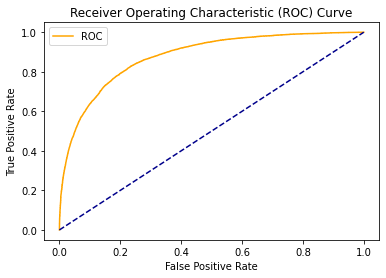

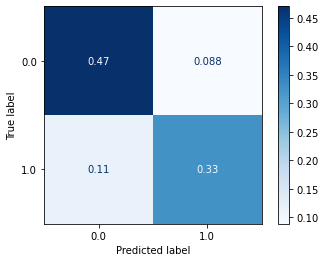

In [23]:

params_lr = {'penalty': 'l1', 'solver':'liblinear'}

model_lr = LogisticRegression(**params_lr)
model_lr, accuracy_lr, roc_auc_lr, coh_kap_lr, tt_lr = run_model(model_lr, X_train, y_train, X_test, y_test)

Accuracy = 0.8700293255131964
ROC Area under Curve = 0.8713122006377182
Cohen's Kappa = 0.738042204160068
Time taken = 0.36644864082336426
              precision    recall  f1-score   support

         0.0    0.90246   0.86040   0.88093     23818
         1.0    0.83306   0.88222   0.85694     18807

    accuracy                        0.87003     42625
   macro avg    0.86776   0.87131   0.86893     42625
weighted avg    0.87184   0.87003   0.87034     42625



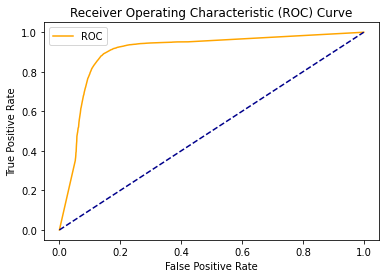

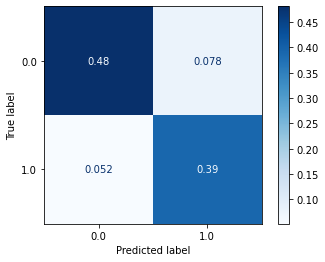

In [24]:
#Decision tree
params_dt = {'max_depth': 16,
             'max_features': "sqrt"}

model_dt = DecisionTreeClassifier(**params_dt)
model_dt, accuracy_dt, roc_auc_dt, coh_kap_dt, tt_dt = run_model(model_dt, X_train, y_train, X_test, y_test)

Accuracy = 0.9304164222873901
ROC Area under Curve = 0.9313653755437892
Cohen's Kappa = 0.8594235145142679
Time taken = 21.162160873413086
              precision    recall  f1-score   support

         0.0    0.95076   0.92329   0.93682     23818
         1.0    0.90628   0.93944   0.92256     18807

    accuracy                        0.93042     42625
   macro avg    0.92852   0.93137   0.92969     42625
weighted avg    0.93113   0.93042   0.93053     42625



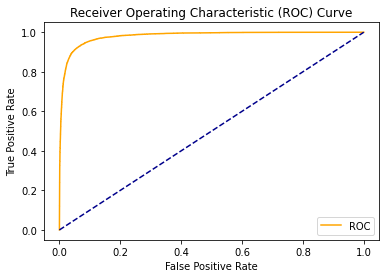

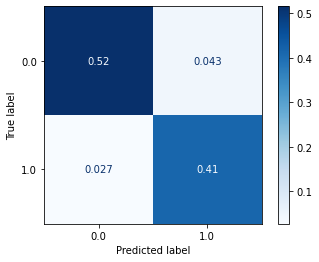

In [25]:
# Random Forest

params_rf = {'max_depth': 16,
             'min_samples_leaf': 1,
             'min_samples_split': 2,
             'n_estimators': 100,
             'random_state': 12345}

model_rf = RandomForestClassifier(**params_rf)
model_rf, accuracy_rf, roc_auc_rf, coh_kap_rf, tt_rf = run_model(model_rf, X_train, y_train, X_test, y_test)

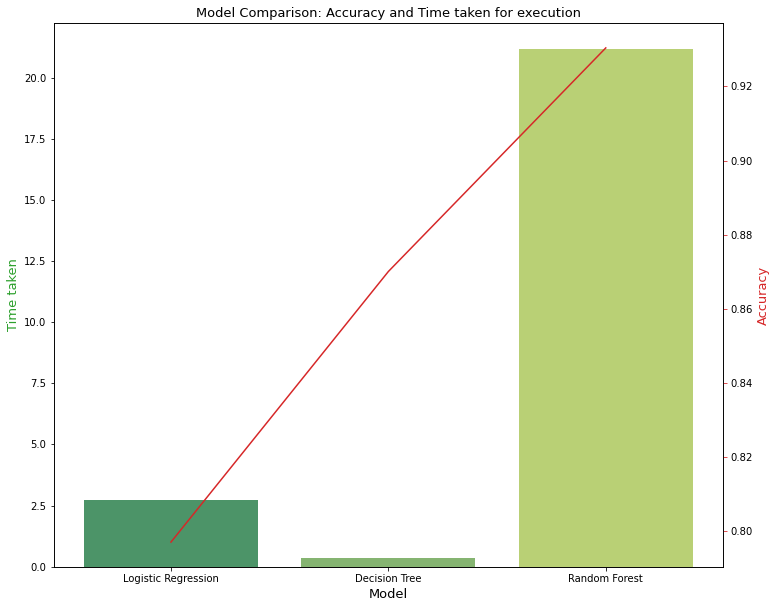

In [30]:
accuracy_scores = [accuracy_lr, accuracy_dt, accuracy_rf]
roc_auc_scores = [roc_auc_lr, roc_auc_dt, roc_auc_rf ]
coh_kap_scores = [coh_kap_lr, coh_kap_dt, coh_kap_rf]
tt = [tt_lr, tt_dt, tt_rf]

model_data = {'Model': ['Logistic Regression','Decision Tree','Random Forest'],
              'Accuracy': accuracy_scores,
              'ROC_AUC': roc_auc_scores,
              'Cohen_Kappa': coh_kap_scores,
              'Time taken': tt}
data = pd.DataFrame(model_data)

fig, ax1 = plt.subplots(figsize=(12,10))
ax1.set_title('Model Comparison: Accuracy and Time taken for execution', fontsize=13)
color = 'tab:green'
ax1.set_xlabel('Model', fontsize=13)
ax1.set_ylabel('Time taken', fontsize=13, color=color)
ax2 = sns.barplot(x='Model', y='Time taken', data = data, palette='summer')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Accuracy', fontsize=13, color=color)
ax2 = sns.lineplot(x='Model', y='Accuracy', data = data, sort=False, color=color)
ax2.tick_params(axis='y', color=color)

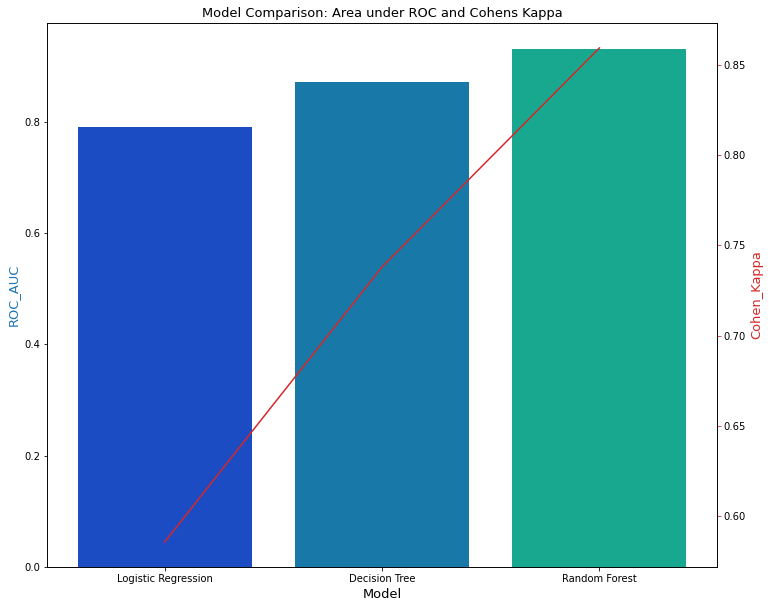

In [31]:
fig, ax3 = plt.subplots(figsize=(12,10))
ax3.set_title('Model Comparison: Area under ROC and Cohens Kappa', fontsize=13)
color = 'tab:blue'
ax3.set_xlabel('Model', fontsize=13)
ax3.set_ylabel('ROC_AUC', fontsize=13, color=color)
ax4 = sns.barplot(x='Model', y='ROC_AUC', data = data, palette='winter')
ax3.tick_params(axis='y')
ax4 = ax3.twinx()
color = 'tab:red'
ax4.set_ylabel('Cohen_Kappa', fontsize=13, color=color)
ax4 = sns.lineplot(x='Model', y='Cohen_Kappa', data = data, sort=False, color=color)
ax4.tick_params(axis='y', color=color)
plt.show()

In [32]:
features.iloc[100]

Location            2.000000
MinTemp             8.200000
MaxTemp            24.000000
Rainfall            0.000000
Evaporation         4.544165
Sunshine           10.305590
WindGustDir        10.000000
WindGustSpeed      17.000000
WindDir9am         10.000000
WindDir3pm         10.000000
WindSpeed9am        7.000000
WindSpeed3pm       13.000000
Humidity9am        60.000000
Humidity3pm        30.000000
Pressure9am      1027.100000
Pressure3pm      1023.400000
Cloud9am            2.598767
Cloud3pm            2.563606
Temp9am            13.800000
Temp3pm            23.500000
RainToday           0.000000
Name: 128, dtype: float64

In [33]:
lencoders = pickle.load(open('encoder.pkl','rb'))
lencoders

{'Date': LabelEncoder(),
 'Location': LabelEncoder(),
 'WindGustDir': LabelEncoder(),
 'WindDir9am': LabelEncoder(),
 'WindDir3pm': LabelEncoder()}

In [34]:
features.columns

Index(['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday'],
      dtype='object')

In [35]:
lencoders.keys()

dict_keys(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'])

In [36]:
def make_prediction(scaler_path,model_path,test_data):
  scaler_custom_loaded = pickle.load(open(scaler_path,'rb'))
  model_custom_loaded = pickle.load(open(model_path,'rb'))
  x_test_data = np.array(test_data).reshape(1,-1)
  x_test_data = scaler_custom_loaded.transform(x_test_data)
  prediction = model_custom_loaded.predict(x_test_data.reshape(1,-1))[0]
  if prediction == 1:
    print('It will Rain')
  else:
    print('It wont Rain tomorrow')

In [45]:

def data_preprocessing(data):
  lst = ['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday']
  for col in ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']:
      data[col] = lencoders[col].transform([data[col]])[0]
  return data

data = data[['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday']]
# x_test_data_series = Data.iloc[100]
# x_test_data_series = data_preprocessing(x_test_data_series)
# x_test_data_series

# x_test_data_series = data_preprocessing(x_test_data_series)
# make_prediction(x_test_data_series)

KeyError: "None of [Index(['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',\n       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',\n       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',\n       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',\n       'Temp3pm', 'RainToday'],\n      dtype='object')] are in the [columns]"

In [42]:
pickle.dump(features,open('data.pkl','wb'))

In [43]:
features = pickle.load(open('data.pkl','rb'))
features.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,2.0,13.4,22.9,0.6,5.950190,7.426974,13.0,44.0,13.0,14.0,...,24.0,71.0,22.0,1007.7,1007.1,8.000000,4.872642,16.9,21.8,0.0
1,2.0,7.4,25.1,0.0,5.854481,11.410383,14.0,44.0,6.0,15.0,...,22.0,44.0,25.0,1010.6,1007.8,1.874353,2.708746,17.2,24.3,0.0
2,2.0,12.9,25.7,0.0,7.982263,12.304774,15.0,46.0,13.0,15.0,...,26.0,38.0,30.0,1007.6,1008.7,1.930208,2.000000,21.0,23.2,0.0
3,2.0,9.2,28.0,0.0,6.194695,11.707860,4.0,24.0,9.0,0.0,...,9.0,45.0,16.0,1017.6,1012.8,1.371248,2.195544,18.1,26.5,0.0
4,2.0,17.5,32.3,1.0,7.050281,5.732326,13.0,41.0,1.0,7.0,...,20.0,82.0,33.0,1010.8,1006.0,7.000000,8.000000,17.8,29.7,0.0


In [58]:
from ibm_watson_machine_learning import APIClient

wml_credentials = { 
   "url":"https://us-south.ml.cloud.ibm.com", 
"apikey":"UIYF9_Yjao9-RAmTTpx2hH1Hxbn-PPMs-To9EiwjH1ka"}


In [89]:
 !pip install --upgrade watson-machine-learning-client-V4

     |████████████████████████████████| 1.3 MB 21.2 MB/s eta 0:00:01
     |████████████████████████████████| 51 kB 1.5 MB/s  eta 0:00:01
     |████████████████████████████████| 5.0 MB 71.0 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 824 kB 70.4 MB/s eta 0:00:01
     |████████████████████████████████| 133 kB 41.1 MB/s eta 0:00:01
     |████████████████████████████████| 547 kB 79.9 MB/s eta 0:00:01
  Created wheel for ibm-cos-sdk: filename=ibm_cos_sdk-2.7.0-py2.py3-none-any.whl size=72565 sha256=45a8f097a549f7f84913786ac65db240b50f43a923769ccbcc11f406968710d4
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/1d/b5/21/f03b3bea83cdb09171e26f0d928efeab508dba4a05e65a9ae2
  Created wheel for ibm-cos-sdk-core: filename=ibm_cos_sdk_core-2.7.0-py2.py3-none-any.whl size=501014 sha256=cdb933cbb31e319335f3b3393ea5df77b7301d0f5c26f5f5fa8ab09d49568daf
  Stored 

In [91]:
client = APIClient(wml_credentials)
def guid_from_space_name(client, space_name):
#  instance_details = client.service_instance.get_details()
 space = client.spaces.get_details()
 return(next(item for item in space['resources'] if item['entity']["name"] == space_name)['metadata']['id'])

space_uid = guid_from_space_name(client,'models')
print(space_uid)

26dd9484-4dee-418e-9a8a-e2c6471ed7d1


In [92]:
client.set.default_space(space_uid)
client.software_specifications.list()

-----------------------------  ------------------------------------  ----
NAME                           ASSET_ID                              TYPE
default_py3.6                  0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
kernel-spark3.2-scala2.12      020d69ce-7ac1-5e68-ac1a-31189867356a  base
pytorch-onnx_1.3-py3.7-edt     069ea134-3346-5748-b513-49120e15d288  base
scikit-learn_0.20-py3.6        09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
spark-mllib_3.0-scala_2.12     09f4cff0-90a7-5899-b9ed-1ef348aebdee  base
pytorch-onnx_rt22.1-py3.9      0b848dd4-e681-5599-be41-b5f6fccc6471  base
ai-function_0.1-py3.6          0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                     0e6e79df-875e-4f24-8ae9-62dcc2148306  base
tensorflow_2.4-py3.7-horovod   1092590a-307d-563d-9b62-4eb7d64b3f22  base
pytorch_1.1-py3.6              10ac12d6-6b30-4ccd-8392-3e922c096a92  base
tensorflow_1.15-py3.6-ddl      111e41b3-de2d-5422-a4d6-bf776828c4b7  base
autoai-kb_rt22.2-py3.10        125b6d9

In [79]:
software_spec_uid = client.software_specifications.get_uid_by_name("default_py3.6")
print(software_spec_uid)

0062b8c9-8b7d-44a0-a9b9-46c416adcbd9


In [82]:
sofware_spec_uid = client.software_specifications.get_id_by_name("runtime-22.1-py3.9")
software_spec_uid

'0062b8c9-8b7d-44a0-a9b9-46c416adcbd9'

In [94]:
meta_data = {client.repository.ModelMetaNames.NAME:'rainfall_model',client.repository.ModelMetaNames.TYPE:'scikit-learn_1.0',client.repository.ModelMetaNames.SOFTWARE_SPEC_UID:sofware_spec_uid}
published_model_rf = client.repository.store_model(model = model_rf,meta_props = meta_data)
published_model_dt = client.repository.store_model(model = model_dt,meta_props = meta_data)
published_model_lr = client.repository.store_model(model = model_lr,meta_props = meta_data)


In [96]:
published_model_rf
published_model_dt 
published_model_lr

{'entity': {'hybrid_pipeline_software_specs': [],
  'software_spec': {'id': '12b83a17-24d8-5082-900f-0ab31fbfd3cb',
   'name': 'runtime-22.1-py3.9'},
  'type': 'scikit-learn_1.0'},
 'metadata': {'created_at': '2022-11-19T18:17:44.893Z',
  'id': 'e2d1e2b6-f608-4042-a9a0-490c88e315f6',
  'modified_at': '2022-11-19T18:17:47.782Z',
  'name': 'rainfall_model',
  'owner': 'IBMid-6630042VG7',
  'resource_key': 'f91147db-89e3-4ac2-a277-3bd51e676a48',
  'space_id': '26dd9484-4dee-418e-9a8a-e2c6471ed7d1'},
 'system': {'warnings': []}}

In [95]:
!wget https://https://raw.githubusercontent.com/IBM/monitor-wml-model-with with-watson-openscale/master/data/additional_feedback_data.json

--2022-11-19 18:17:48--  https://https//raw.githubusercontent.com/IBM/monitor-wml-model-with
Resolving https (https)... failed: Name or service not known.
wget: unable to resolve host address ‘https’
--2022-11-19 18:17:49--  http://with-watson-openscale/master/data/additional_feedback_data.json
Resolving with-watson-openscale (with-watson-openscale)... failed: Name or service not known.
wget: unable to resolve host address ‘with-watson-openscale’
